In [1]:
import sentencepiece as spm

import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import urllib.request

%matplotlib inline

# 전체 리뷰 데이터 불러오기

In [2]:
review_path = os.getenv('HOME')+'/aiffel/nlp2/data/ratings.txt'
review_data = pd.read_table(review_path)

In [3]:
review_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


# SentencePiece에 활용하기 위해 내용 부분만 리스트로 변환

In [4]:
review_list = list(np.array(review_data['document'].tolist()))
review_list

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ',
 '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.',
 '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.',
 '와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.',
 '사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화',
 '완전 감동입니다 다시봐도 감동',
 '개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음',
 '굿',
 '바보가 아니라 병 쉰 인듯',
 '내 나이와 같은 영화를 지금 본 나는 감동적이다..하지만 훗날 다시보면대사하나하나 그 감정을완벽하게 이해할것만 같다...',
 '재밌다',
 '고질라니무 귀엽다능ㅋㅋ',
 '영화의 오페라화라고 해야할 작품. 극단적 평갈림은 어쩔 수 없는 듯.',
 '3도 반전 좋았제 ^^',
 '평점 왜 낮아? 긴장감 스릴감 진짜 최고인데 진짜 전장에서 느끼는 공포를 생생하게 전해준다.',
 '네고시에이터랑 소재만 같을 뿐.. 아무런 관련없음..',
 '단연 최고',
 '가면 갈수록 더욱 빠져드네요 밀회 화이팅!!',
 '어?생각없이 봤는데 상당한 수작.일본영화 10년내 최고로 마음에 들었다.강렬한 임팩트가 일품.',
 '오랜만에 본 제대로 된 범죄스릴러~',
 "그런 때가 있었다. ('사랑해'도 아니고) 그저 좋아한다는 한 마디 말을 꺼내기도 벅차서 밤 잠 설치던 때. 커징텅의 교복에 남은 션자이의 볼펜 자국 역시 미처 다 전하지 못한 마음의 형태인 거다.",
 '마지막씬을 잊을수가 없다',
 '강압적용서,세뇌적용서에 대한 비판',
 '중세시대명작. 굿 평점이왜이래',
 '7시간짜리 영상이 존재한다면, 죽기전에 꼭 한번 보고싶다. 아름답고 슬픈 OST

# 리스트 변환 및 데이터 확인

In [5]:
print("Data Size:", len(review_list))

print("Example:")
for sen in review_data['document'][0:100][::20]: print(">>", sen)

Data Size: 200000
Example:
>> 어릴때보고 지금다시봐도 재밌어요ㅋㅋ
>> 오랜만에 본 제대로 된 범죄스릴러~
>> 정의를 세우는 콜트, 콜텍 노동자들 이야기
>> 상당히 훌륭한 영화...
>> 내가 없어질 내인생. 제목을 참 잘 지었다.


# 문장 분포 확인

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 35


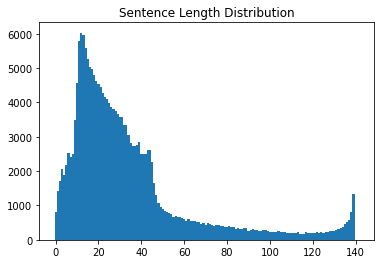

In [6]:
min_len = 999
max_len = 0
sum_len = 0

for sen in review_list:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review_list))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review_list:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 중복 데이터 제거 후 데이터 확인

Data Size: 194544
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


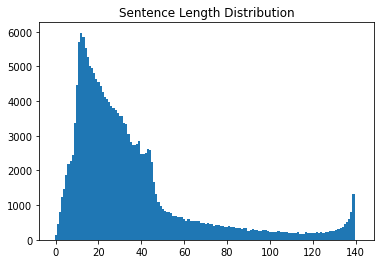

In [9]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(review_list))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# Exploration 07에서 네이버 리뷰 데이터로 미리 계산한 평균 + 3표준편차로 최대길이 설정

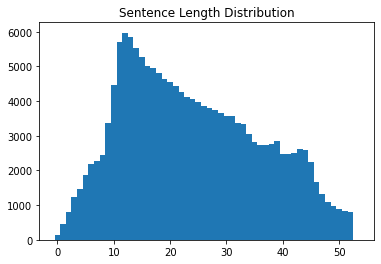

In [10]:
max_len = 54
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# SentencePiece 생성

In [11]:
temp_file = os.getenv('HOME')+'/aiffel/nlp2/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 374913 Dec  8 06:21 korean_spm.model
-rw-r--r-- 1 root root 144281 Dec  8 06:21 korean_spm.vocab


In [12]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

# train 데이터 및 test 데이터 불러오기

In [13]:
train_data = pd.read_table('~/aiffel/nlp2/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/nlp2/data/ratings_test.txt')

# load_data 함수

In [36]:
def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    word_index = {}
    index_word = {}
    
    x_train = []        
    for sentence in train_data['document']:
        x_train.append(s.EncodeAsIds(sentence))
    
    x_test = []
    for sentence in test_data['document']:
        x_test.append(s.EncodeAsIds(sentence))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post',maxlen=max_len)
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post',maxlen=max_len)
          
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_index, index_word

# 데이터 로드 진행

In [37]:
x_train, y_train, x_test, y_test, word_index, index_word = load_data(train_data, test_data)

In [38]:
x_train.shape

(146182, 54)

In [39]:
x_test.shape

(49157, 54)

# train 데이터를 train 데이터와 validation 데이터로 분할

In [40]:
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 12)
print(x_train_split.shape)
print(y_train_split.shape)

(116945, 54)
(116945,)


# Tokenizer에 따른 차이를 비교하기 위해 Exploration 07에서 85%의 accuracy를 보여준 모델과 같은 모델 사용

In [41]:
word_vector_dim = 16

model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.LSTM(256))
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               279552    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 473,601
Trainable params: 473,601
Non-trainable params: 0
_________________________________________________________________


# 학습

In [42]:
model_1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_1 = model_1.fit(x_train_split, y_train_split, epochs=5, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/5
1828/1828 [==============================] - 38s 20ms/step - loss: 0.6894 - accuracy: 0.5166 - val_loss: 0.6498 - val_accuracy: 0.6254
Epoch 2/5
1828/1828 [==============================] - 36s 20ms/step - loss: 0.6556 - accuracy: 0.6125 - val_loss: 0.6932 - val_accuracy: 0.5023
Epoch 3/5
1828/1828 [==============================] - 37s 20ms/step - loss: 0.6930 - accuracy: 0.5051 - val_loss: 0.6927 - val_accuracy: 0.5023
Epoch 4/5
1828/1828 [==============================] - 36s 20ms/step - loss: 0.6883 - accuracy: 0.5171 - val_loss: 0.6071 - val_accuracy: 0.7008
Epoch 5/5
1828/1828 [==============================] - 36s 20ms/step - loss: 0.6193 - accuracy: 0.6821 - val_loss: 0.4269 - val_accuracy: 0.8047


# test 데이터 적용
# 한번에 80.9%라는 accuracy 목표치 도달

In [43]:
results_1 = model_1.evaluate(x_test,  y_test, verbose=2)

print(results_1)

1537/1537 - 8s - loss: 0.4252 - accuracy: 0.8090
[0.42523735761642456, 0.8090404272079468]


# 학습 커브 시각화

In [22]:
history_1_dict = history_1.history

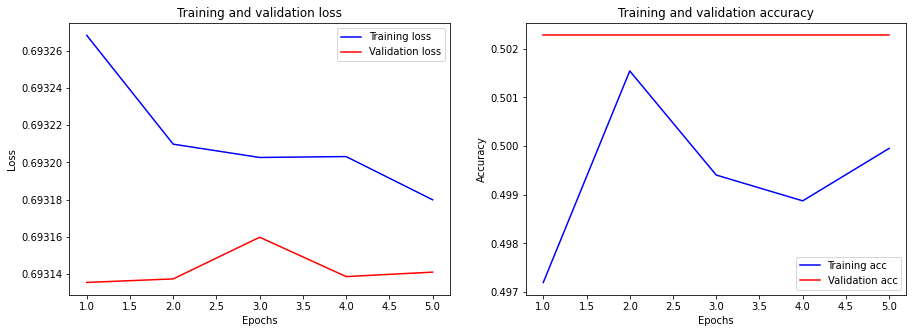

In [23]:
import matplotlib.pyplot as plt

acc = history_1_dict['accuracy']
val_acc = history_1_dict['val_accuracy']
loss = history_1_dict['loss']
val_loss = history_1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 비교를 위해 첨부한 같은 모델에서 형태소 분석기를 사용했을 경우(exploration 07)의 학습 커브

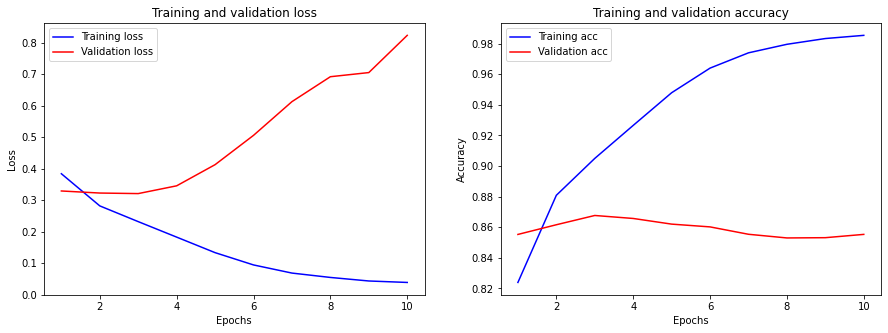

In [19]:
from IPython.display import Image
Image(os.getenv('HOME')+'/aiffel/exp7_traincurve.png')

***

# 고찰

Exploration 07에서 사용했던 네이버 영화 리뷰 데이터를 사용하여 진행된 프로젝트입니다.  
Exploration 07에서는 형태소분석기를 토큰화에 사용하였는데 이번 프로젝트에서는 SentencePiece를 활용하였습니다.  
  

  
### 같은 모델에서 형태소 분석기를 사용했을 경우(exploration 07)의 test_accuracy : 85.47%
### 같은 모델에서 SentencePiece를 사용했을 경우의 test_accuracy : 80.90%

  
기본적으로 형태소 분석기를 사용했을 때의 성능이 더 좋은 것으로 나온다.  
학습 커브를 보더라도 형태소 분석기를 사용했을 경우가 SentencePiece를 사용했을 때 보다 학습이 더 안정적이다.  
나중에 노드에 나온 것이라 내심 SentencePiece의 성능이 더 좋지 않을까 싶었는데 역시 한글에는 형태소 분석기가 더 최적화 되어 있는 듯 하다.  
하지만 알아보니 SentencePiece의 경우 범용적인 tokenizer로 만들어진터라 경우에 따라서는 한글에서도 더 좋은 성능을 낼 때도 있다고 한다.  
이렇게 데이터의 종류에 따라서 어떤 tokenizer를 사용하느냐에 따라 성능 차이가 발생하는 만큼 매번 다양한 tokenizer를 적용해 보아야한다고 한다.